In [1]:
import hddCRP.modelFitting
import hddCRP.simulations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [5]:
M = 3;
R = 4
syms = list(range(M))
Y = np.array(syms * R).reshape((R,M)).flatten(order='F')
Y = np.append(Y,Y)
N = Y.size;
grps = np.zeros((N,2),dtype=int)
grps[:int(N/2),1] = 1

D = np.ones((N,N))
alphas = [1,2];

print(Y)
print(grps.T)

[0 0 0 0 1 1 1 1 2 2 2 2 0 0 0 0 1 1 1 1 2 2 2 2]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]


In [6]:
model = hddCRP.modelFitting.hddCRPModel(Y=Y, groupings=grps, alpha=alphas, D=D)
model._validate_internals("INIT")

In [11]:
codes = model.run_gibbs_sweep(DEBUG_MODE=True)
print(codes)

[[2 3]
 [3 3]
 [2 3]
 [2 5]
 [5 0]
 [2 1]
 [5 5]
 [1 0]
 [2 2]
 [3 1]
 [5 4]
 [2 2]
 [5 0]
 [5 0]
 [5 0]
 [4 0]
 [1 0]
 [5 5]
 [3 5]
 [4 5]
 [4 1]
 [1 5]
 [5 0]
 [1 5]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [12]:
model._validate_print_before_and_after()

CB_tables_values 
[1 0 0 2 2]
CB_tables 
[[0 3 0 3 0 0 0 0 3 3 3 0 0 3 0 0 0 0 0 3 0 0 3 3]
 [1 1 1 1 0 0 0 0 4 3 4 4 2 2 2 2 0 0 0 0 3 3 3 3]]
CB_ptr 
[[21  9 16 10 17  4 14 18 13 23  1 21 11  3 21 14 14 21  7 19 14  7 23 19]
 [ 2  2  0  1  4  4  7  7 10  9  8  8 14 14 15 13 16 17 18 18 22 22 22 23]]
CB_is_cycle 
[[False False False False False False False  True False False False False
  False False False False False False  True  True False False False False]
 [ True False  True False False False False False  True False  True False
  False  True  True  True False False False False False False False False]]
CB_y 
[[1 2 1 2 1 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 1 1 2 2]
 [0 0 0 0 1 1 1 1 2 2 2 2 0 0 0 0 1 1 1 1 2 2 2 2]]
CB_num_labeled_upstream 
[[0 0 0 0 2 0 0 6 0 1 0 0 0 0 1 0 1 3 2 5 0 4 3 5]
 [1 2 3 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 3 1]]
CB_num_labeled_in_table 
[8 4 4 5 3]
CB_predecessors 
[[[], [10], [], [13], [5], [], [], [18, 21], [], [1], [3], [12], [], [8], [6, 15, 16, 20], [],

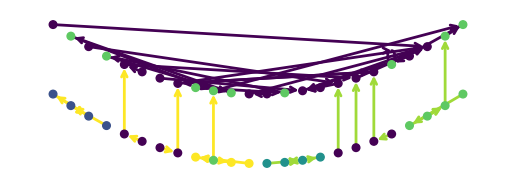

In [13]:


# connection_data2= {"C_y" : model._CB_tables, "C_ctx" : grps, "session_lengths" : [model.N], "C_ptr" : model._CB_ptr}
# ax2 = plt.subplot(2,1,1)
# hddCRP.simulations.make_graph_plot(connection_data2, ax2, hs = 10, hh = 10)
# plt.show

connection_data= {"C_y" : model._C_tables, "C_ctx" : grps, "session_lengths" : [model.N], "C_ptr" : model._C_ptr}
ax = plt.subplot(2,1,2)
hddCRP.simulations.make_graph_plot(connection_data, ax, hs = 10, hh = 10)
plt.show()


In [14]:

print(model._CB_num_labeled_upstream.T)
print(model._C_num_labeled_upstream.T)

[[0 0 0 0 2 0 0 6 0 1 0 0 0 0 1 0 1 3 2 5 0 4 3 5]
 [1 2 3 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 3 1]]
[[0 0 0 0 2 0 0 6 0 1 0 0 0 0 1 0 1 3 2 5 0 4 4 5]
 [1 2 3 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 2 1 4 1]]


In [ ]:
print(model._C_is_cycle.T)

In [ ]:
can_connect_to, post, *_ = model._post_for_single_nodes_connections(0, 0);
print(can_connect_to)
print(post)

In [15]:
# run test on Gibbs probs
from scipy.special import logsumexp

stop = False
for layer in range(2):
    for node in range(12):
        start_con = model._C_ptr[node,layer];

        table_cnts = np.array([np.sum(model._C_table_values == yy) for yy in range(model.M)])

        can_connect_to, post, table_count_delta, Y_change, p_Y, p_C = model._post_for_single_nodes_connections(node, layer, print_msgs=False);
        post = post/sum(post)
        # print(table_cnts)
        # print(table_count_delta)
        # print(Y_change)
        # print(can_connect_to)
        # print(model._C_is_cycle.T)
        # print(model._C_ptr[6,layer]):
        t1 = model._C_is_cycle[node,layer]
        y1 = model._C_y[node,layer]
        destination_Y = model._C_y[can_connect_to,layer]
        destination_tables = model._C_tables[can_connect_to,layer]
        if(layer > 0):
            destination_Y[can_connect_to == node] = model._C_y[node,layer-1]
            destination_tables[can_connect_to == node] = model._C_tables[node,layer-1]
        out_of_table = destination_tables !=  model._C_tables[node,layer]
        destination_Y2 = model._C_table_values[destination_tables];
        # print("out_of_table_a " + str(out_of_table ))
        # print("destination_tables_a " + str(destination_tables ))
        # print("destination_Y_a " + str(destination_Y ))
        # print("f1b " + str((destination_Y != -1) ))
        # print("f1v " + str((destination_Y == destination_Y2) ))
        # print("f1 " + str(out_of_table & (destination_Y != -1)))
        # print("t1 " + str(t1))
        # print("y1 " + str(y1))

        lps = np.zeros((len(can_connect_to)))
        for ii, node_to in enumerate(can_connect_to):
            c_type = model._set_connection(node, node_to, layer)
            model._validate_internals(ii)

            table_cnts_2 = np.array([np.sum(model._C_table_values == yy) for yy in range(model.M)])
            table_cnts_3 = table_cnts.copy()
            if(Y_change[ii] >= 0):
                table_cnts_3[Y_change[ii] ] += table_count_delta[ii]
            if(not np.all(table_cnts_3 == table_cnts_2)):
                print("original cnt " + str(table_cnts))
                print(table_count_delta)
                print("real cnt " + str(table_cnts_2))
                print("predicted cnt " + str(table_cnts_3))
                print("table est is off " + str(c_type) + " " + str(node_to) + "(" + str(ii) + ")")
                stop = True;
                # raise("table est is off")


            lps[ii] = model.compute_log_likelihood()

            can_connect_to_c, post_c, _, _, p_Y_c, p_C_c = model._post_for_single_nodes_connections(node, layer);
            post_c = post_c/sum(post_c)

            if(not np.all(np.isin(can_connect_to_c, can_connect_to)) or not np.all(np.isin(can_connect_to, can_connect_to_c))):
                print("can_connect_to_c " + str(can_connect_to_c))
                print("can_connect_to " + str(can_connect_to))
                print("can_connect_to shouldn't change " + str(c_type) + " " + str(node_to))
                stop = True;
                #raise RuntimeError("can_connect_to shouldn't change")
            if(np.max(np.abs(post_c-post)) > 1e-8):
                print("post " + str(post))
                print("post_c " + str(post_c))
                print("p_Y " + str(p_Y))
                print("p_Y_c " + str(p_Y_c))
                print("p_C " + str(p_C))
                print("p_C_c " + str(p_C_c))
                print("post shouldn't change " + str(c_type) + " " + str(node_to))
                stop = True;
                #raise RuntimeError("post shouldn't change")
            model._set_connection(node, start_con, layer);
            
        post_2 = np.exp(lps - logsumexp(lps))
        post_2 = post_2 / np.sum(post_2)

        # print(post)
        # print(post_2)
        if(np.max(np.abs(post_2-post)) > 1e-8):
            print("post " + str(post))
            print("post_c " + str(post_2))
            print("outer post shouldn't change " + str(node))
            stop = True;
        model._set_connection(node, start_con, layer);
        if(stop):
            break
    
    if(stop):
        break
if(not stop):
    print("all good")

all good


In [ ]:
model._set_connection(node, 2, layer)

In [7]:
node

11

In [ ]:
model._set_connection(node, 5, layer);
group_num = model._groupings_compact[node,layer];
table_num = model._C_tables[node,layer];
Y_type = model._C_y[node,layer]

can_connect_to = model._group_indicies[layer][group_num]; # in group
print(can_connect_to)
print(model._C_y[can_connect_to,layer])
print(Y_type)
if(Y_type != -1):
    can_connect_to = can_connect_to[np.isin(model._C_y[can_connect_to,layer], [-1, Y_type])]; # possible observation
if(layer > 0 and not np.isin(model._C_y[node,layer-1], [-1, Y_type])): # connection to upper layers must also have correct label
    can_connect_to = can_connect_to[can_connect_to != node];
print(can_connect_to)
